In [1]:
import arviz as az
import bambi as bmb
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from scipy import stats

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
plt.style.use("intuitivebayes.mplstyle")

mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.spines.left"] = False

# Football Analytics

In [3]:
df = pd.read_csv("../data/season-1718_csv.csv", parse_dates=["Date"], date_format="%d/%m/%y")
print(df.shape)


(380, 65)


In [4]:
df = df.rename({"FTHG": "GoalsHome", "FTAG": "GoalsAway"}, axis=1)

first_game = df["Date"].min()
df["Days_Since_First_Game"] = (df["Date"] - first_game).dt.days
cols = df.columns[[2, 3, 4, 5, -1]]
df = df[cols]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   HomeTeam               380 non-null    object
 1   AwayTeam               380 non-null    object
 2   GoalsHome              380 non-null    int64 
 3   GoalsAway              380 non-null    int64 
 4   Days_Since_First_Game  380 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 15.0+ KB


In [5]:
df.head()

,HomeTeam,AwayTeam,GoalsHome,GoalsAway,Days_Since_First_Game
0,Arsenal,Leicester,4,3,0
1,Brighton,Man City,0,2,1
2,Chelsea,Burnley,2,3,1
3,Crystal Palace,Huddersfield,0,3,1
4,Everton,Stoke,1,0,1


In [7]:
# separate home and away stats for each team
home_goals = (
    df[["HomeTeam", "GoalsHome", "Days_Since_First_Game"]]
        .assign(GameType="Home")
        .rename({"HomeTeam": "Team", "GoalsHome": "Goals"}, axis=1)
)
away_goals = (
    df[["AwayTeam", "GoalsAway", "Days_Since_First_Game"]]
        .assign(GameType="Away")
        .rename({"AwayTeam": "Team", "GoalsAway": "Goals"}, axis=1)
)

football_df = pd.concat([home_goals, away_goals], axis=0)
football_df.head()

,Team,Goals,Days_Since_First_Game,GameType
0,Arsenal,4,0,Home
1,Brighton,0,1,Home
2,Chelsea,2,1,Home
3,Crystal Palace,0,1,Home
4,Everton,1,1,Home


## Home versus Away Effect
* task- what is there an effect of playing Home vs. Away on #(goals) 

* a comparison between two models:
    * model #(goals) for each team using a global Home vs away effect, and an offset for each team 
    *  model #(goals) for each team using a local Home vs away effect
        * an interaction between team and type of game (Home/Away)
* **Unidentifialility**- given total #(goals) of a team, and its Home/Away #(goals) we can infer\
Away/Home #(goals)
    * Pivoting- model total #(goals) of a team and difference in #(goals) between Home and Away

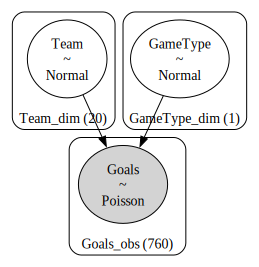

In [8]:
global_game_type_model = bmb.Model(
    formula="Goals ~ 0 + Team + GameType",  # add home effect for each team, to the team effect
    data=football_df,
    family="poisson")

global_game_type_model.build()
global_game_type_model.graph()

In [9]:
global_game_type_idata = global_game_type_model.fit(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Team, GameType]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [10]:
az.summary(global_game_type_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Team[Arsenal],0.502,0.119,0.293,0.738,0.002,0.001,3955.0,1738.0,1.00
Team[Bournemouth],0.001,0.162,-0.309,0.297,0.002,0.004,4322.0,1673.0,1.00
Team[Brighton],-0.284,0.175,-0.622,0.016,0.003,0.003,4097.0,1241.0,1.00
Team[Burnley],-0.229,0.172,-0.548,0.115,0.003,0.003,4001.0,1638.0,1.00
Team[Chelsea],0.324,0.130,0.084,0.563,0.002,0.001,5211.0,1711.0,1.00
Team[Crystal Palace],0.002,0.144,-0.268,0.277,0.002,0.004,3850.0,1607.0,1.01
Team[Everton],-0.022,0.158,-0.331,0.262,0.002,0.004,4433.0,1540.0,1.00
Team[Huddersfield],-0.475,0.187,-0.807,-0.104,0.003,0.002,5208.0,1131.0,1.00
Team[Leicester],0.218,0.145,-0.036,0.505,0.002,0.002,3724.0,1550.0,1.00
Team[Liverpool],0.635,0.116,0.418,0.850,0.002,0.001,4995.0,1391.0,1.00


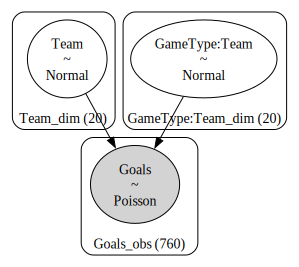

In [11]:
local_game_type_model = bmb.Model(
    formula="Goals ~ 0 + Team + GameType:Team",  # add home - away effect for each team
    data=football_df,
    family="poisson")

local_game_type_model.build()
local_game_type_model.graph()

In [12]:
local_game_type_idata = local_game_type_model.fit(idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Team, GameType:Team]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 19 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [13]:
az.summary(local_game_type_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Team[Arsenal],0.027,0.231,-0.423,0.431,0.004,0.005,2961.0,1631.0,1.00
Team[Bournemouth],-0.025,0.231,-0.425,0.417,0.004,0.006,3193.0,1579.0,1.00
Team[Brighton],-0.701,0.322,-1.324,-0.128,0.006,0.005,2861.0,1596.0,1.00
Team[Burnley],0.029,0.230,-0.446,0.415,0.004,0.005,3069.0,1542.0,1.00
Team[Chelsea],0.510,0.177,0.190,0.862,0.003,0.002,3801.0,1318.0,1.00
Team[Crystal Palace],-0.204,0.256,-0.689,0.268,0.005,0.005,2697.0,1392.0,1.00
Team[Everton],-0.199,0.243,-0.639,0.258,0.005,0.004,2485.0,1528.0,1.00
Team[Huddersfield],-0.500,0.298,-1.052,0.019,0.006,0.005,2462.0,1640.0,1.00
Team[Leicester],0.474,0.179,0.147,0.801,0.003,0.002,2826.0,1516.0,1.00
Team[Liverpool],0.710,0.164,0.414,1.031,0.003,0.002,3165.0,1535.0,1.00


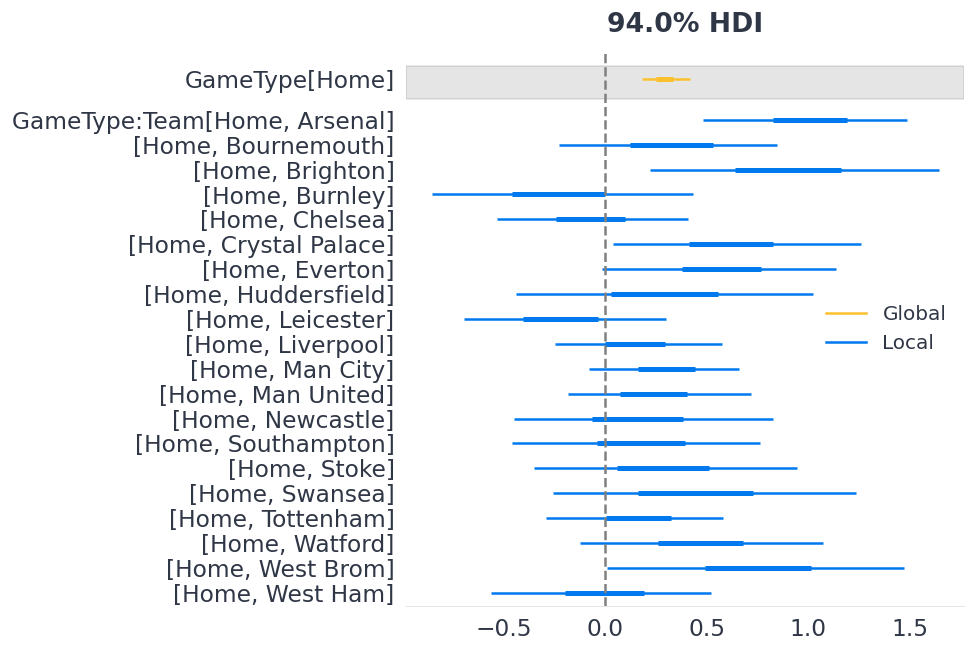

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
az.plot_forest(
    [local_game_type_idata, global_game_type_idata],
    model_names=["Local", "Global"],
    var_names=["GameType"],
    filter_vars="like",
    combined=True,
    ax=ax
)
ax.axvline(0, c="grey", lw=1.5, ls="--")

## LOO Model Comparison
* Compare models based on their expected log pointwise predictive density (ELPD).
* The ELPD is estimated either by Pareto smoothed importance sampling leave-one-out cross-validation (PSISLOO CV)
using the widely applicable information criterion (WAIC).
* results- the global model is (supposedly better)
    * global is the best model- higher ELPD_loo
    * there is no overlap between the ELPD_diff CI and ELPD_loo of the best model (global)

In [15]:
models = {"Local": local_game_type_idata, "Global": global_game_type_idata}
df_compare = az.compare(models)
df_compare

/home/studio-lab-user/.conda/envs/ib_advanced_regression/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/home/studio-lab-user/.conda/envs/ib_advanced_regression/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Global,0,-1101.218830,20.601541,0.000000,0.7874,18.978745,0.000000,False,log
Local,1,-1108.772637,39.168755,7.553807,0.2126,19.683723,5.259021,False,log


/home/studio-lab-user/.conda/envs/ib_advanced_regression/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


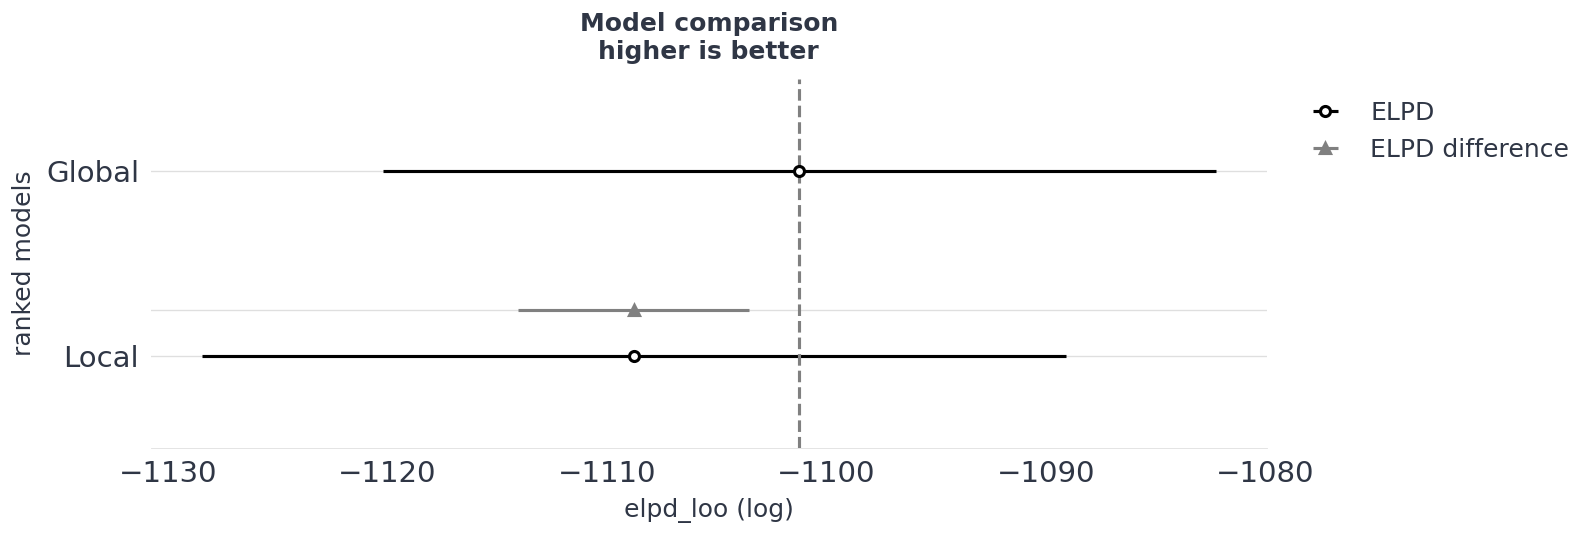

In [16]:
az.plot_compare(df_compare, insample_dev=False, figsize=(12, 4));

# Fishing Model
* task- how many fish were caught by fishermen (`count`) at a state park
* features:
    * `camper`- if they camped
    * `persons`- how many people were in the group
    * `child`- how many children were in the group (if any)
    * `livebait`- if they used a livebait (ignored)
* notes:
    * some of the fishermen didn't catch any fish (Poisson)
    * some people were not came to the park with the intent to fish (inflation)

In [17]:
fish_data = pd.read_stata(
    "../data/fish.dta",
    columns=["count", "livebait", "camper", "persons", "child"],
)

fish_data["livebait"] = pd.Categorical(fish_data["livebait"])
fish_data["camper"] = pd.Categorical(fish_data["camper"])
print(fish_data)
fish_data.info()

     count livebait camper  persons  child
0      0.0      0.0    0.0      1.0    0.0
1      0.0      1.0    1.0      1.0    0.0
2      0.0      1.0    0.0      1.0    0.0
3      0.0      1.0    1.0      2.0    1.0
4      1.0      1.0    0.0      1.0    0.0
..     ...      ...    ...      ...    ...
245    0.0      1.0    1.0      2.0    0.0
246    0.0      1.0    1.0      4.0    3.0
247    0.0      1.0    1.0      2.0    1.0
248    0.0      1.0    1.0      3.0    2.0
249    0.0      1.0    1.0      2.0    1.0

[250 rows x 5 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   count     250 non-null    float32 
 1   livebait  250 non-null    category
 2   camper    250 non-null    category
 3   persons   250 non-null    float32 
 4   child     250 non-null    float32 
dtypes: category(2), float32(3)
memory usage: 3.7 KB


## Models
* ZIP (Zero Inflated Poisson) using Bambi and PyMC
* ZINB (Zero Inflated Negative Binomial) in PyMC

In [19]:
fish_data["count"].describe()

count    250.000000
mean       3.296000
std       11.635025
min        0.000000
25%        0.000000
50%        0.000000
75%        2.000000
max      149.000000
Name: count, dtype: float64

<Axes: xlabel='count', ylabel='Count'>

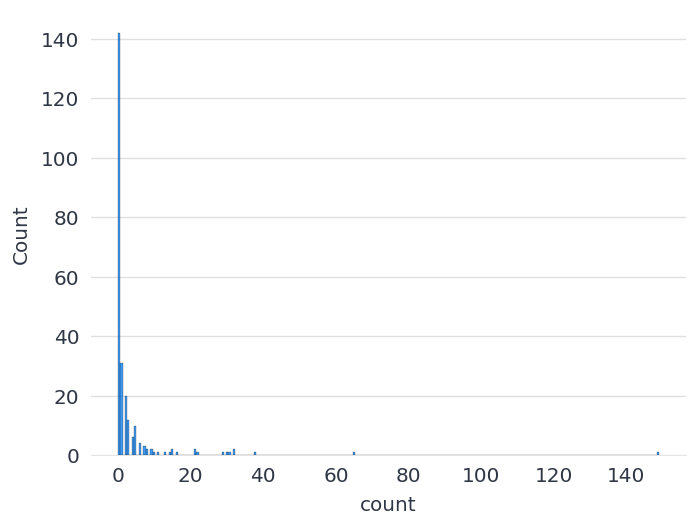

In [20]:
sns.histplot(fish_data["count"])

## Scaling for Baseline Interpretation
* scale persons, because of the interpretation of the intercept (baseline point):
    * intercept (without sacling)- no camper, with 0 persons (impossible) and 0 children
    * intercept (with scaling)- no camper, with mean persons, and 0 children.

### Modeling $\psi$
* $\psi = P(Z= \text{Poisson})$- probability of entering Poisson process
    * $\psi \sim \text{Beta}(\alpha, \beta)$
    * $\psi = \sigma(X_{\psi}\beta_{\psi})$- Logitic Regression model

/home/studio-lab-user/.conda/envs/ib_advanced_regression/lib/python3.11/site-packages/formulae/terms/variable.py:87: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_string_dtype(x) or is_categorical_dtype(x):


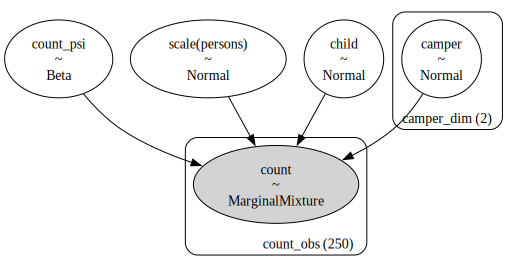

In [21]:
# simpler model, where psi is beta distributed
# decrease σ for the priors, since we use exponentiate our model (exp- inverse link function)
common_priors = {"common": bmb.Prior("Normal", mu=0, sigma=0.5)}

zip_fish_simple = bmb.Model(
    "count ~ 0 + camper + scale(persons) + child",
    fish_data, 
    family='zero_inflated_poisson',
    priors=common_priors,
)
zip_fish_simple.build()
zip_fish_simple.graph()

In [24]:
# psi is modeled using logistic regression with an intercept and #(children)
formula = bmb.Formula(
    "count ~ 0 + camper + scale(persons) + child", # Poisson rate, mu
    "psi ~ 1 + child"    # Probability of entering Poisson process, psi 
)
common_priors = {
    "common": bmb.Prior("Normal", mu=0, sigma=0.5),
    "psi": {"common": bmb.Prior("Normal", mu=0, sigma=0.5)},
}

bmb_zip_model = bmb.Model(
    formula, 
    fish_data, 
    family='zero_inflated_poisson',
    priors=common_priors,
)
bmb_zip_model

/home/studio-lab-user/.conda/envs/ib_advanced_regression/lib/python3.11/site-packages/formulae/terms/variable.py:87: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_string_dtype(x) or is_categorical_dtype(x):


       Formula: count ~ 0 + camper + scale(persons) + child
                psi ~ 1 + child
        Family: zero_inflated_poisson
          Link: mu = log
                psi = logit
  Observations: 250
        Priors: 
    target = mu
        Common-level effects
            camper ~ Normal(mu: 0.0, sigma: 0.5)
            scale(persons) ~ Normal(mu: 0.0, sigma: 0.5)
            child ~ Normal(mu: 0.0, sigma: 0.5)
    target = psi
        Common-level effects
            psi_Intercept ~ Normal(mu: 0.0, sigma: 0.5)
            psi_child ~ Normal(mu: 0.0, sigma: 0.5)

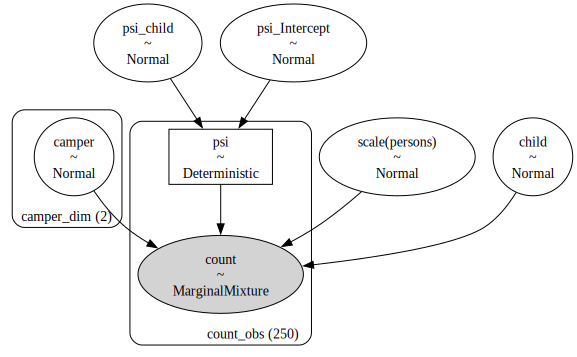

In [25]:
bmb_zip_model.build()
bmb_zip_model.graph()

In [26]:
bmb_zip_idata = bmb_zip_model.fit()
az.summary(bmb_zip_idata, var_names=["~psi"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [camper, scale(persons), child, psi_Intercept, psi_child]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
camper[0.0],1.144,0.096,0.957,1.312,0.002,0.001,2130.0,1654.0,1.00
camper[1.0],1.934,0.063,1.815,2.047,0.002,0.001,1633.0,1546.0,1.00
scale(persons),0.995,0.052,0.902,1.092,0.001,0.001,1340.0,1634.0,1.01
child,-1.142,0.096,-1.317,-0.965,0.002,0.001,2082.0,1399.0,1.00
psi_Intercept,0.810,0.222,0.417,1.239,0.005,0.003,2167.0,1687.0,1.00
psi_child,-0.993,0.224,-1.414,-0.573,0.005,0.003,2380.0,1609.0,1.00


In [29]:
bmb_zip_model.components

{'count': <bambi.model_components.DistributionalComponent at 0x7f4751903b10>,
 'psi': <bambi.model_components.DistributionalComponent at 0x7f47488095d0>}

/home/studio-lab-user/.conda/envs/ib_advanced_regression/lib/python3.11/site-packages/bambi/interpret/utils.py:373: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_string_dtype(x) or is_categorical_dtype(x):
/home/studio-lab-user/.conda/envs/ib_advanced_regression/lib/python3.11/site-packages/bambi/interpret/plotting.py:227: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(cap_data[covariates.main]) or is_string_dtype(


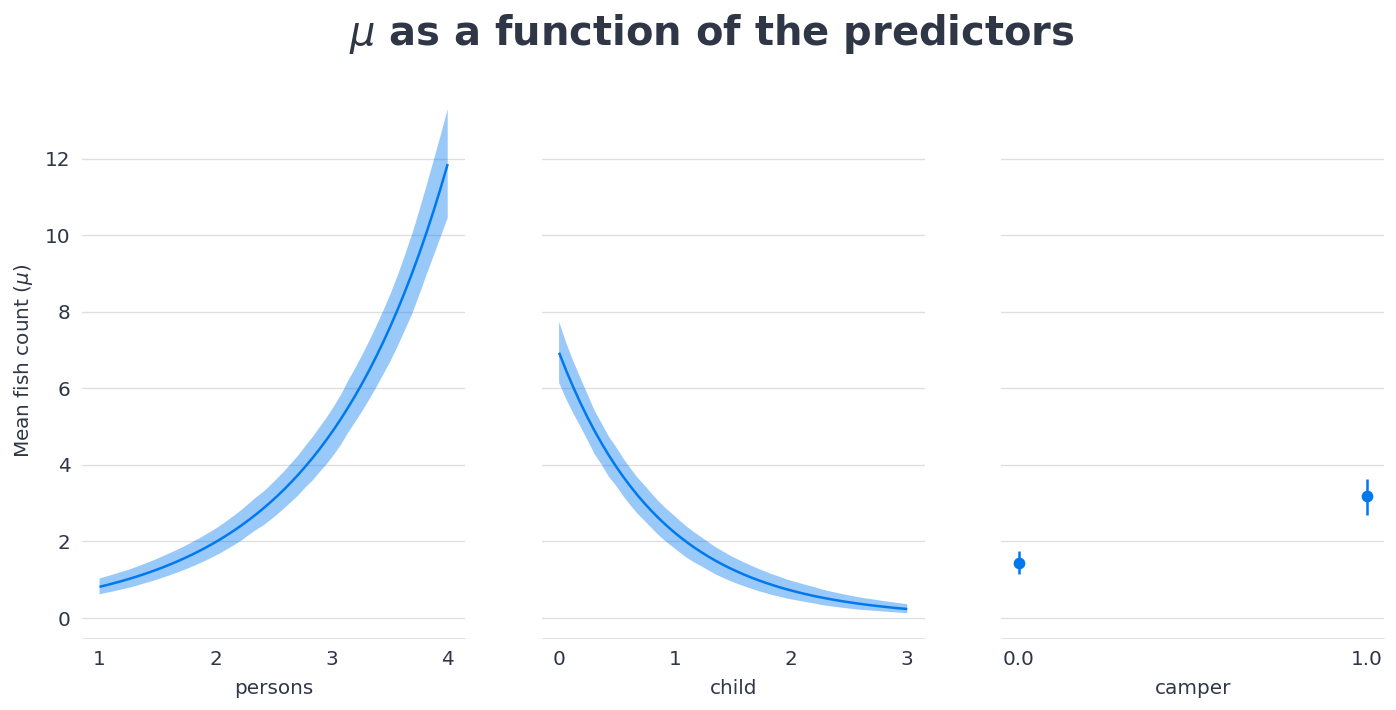

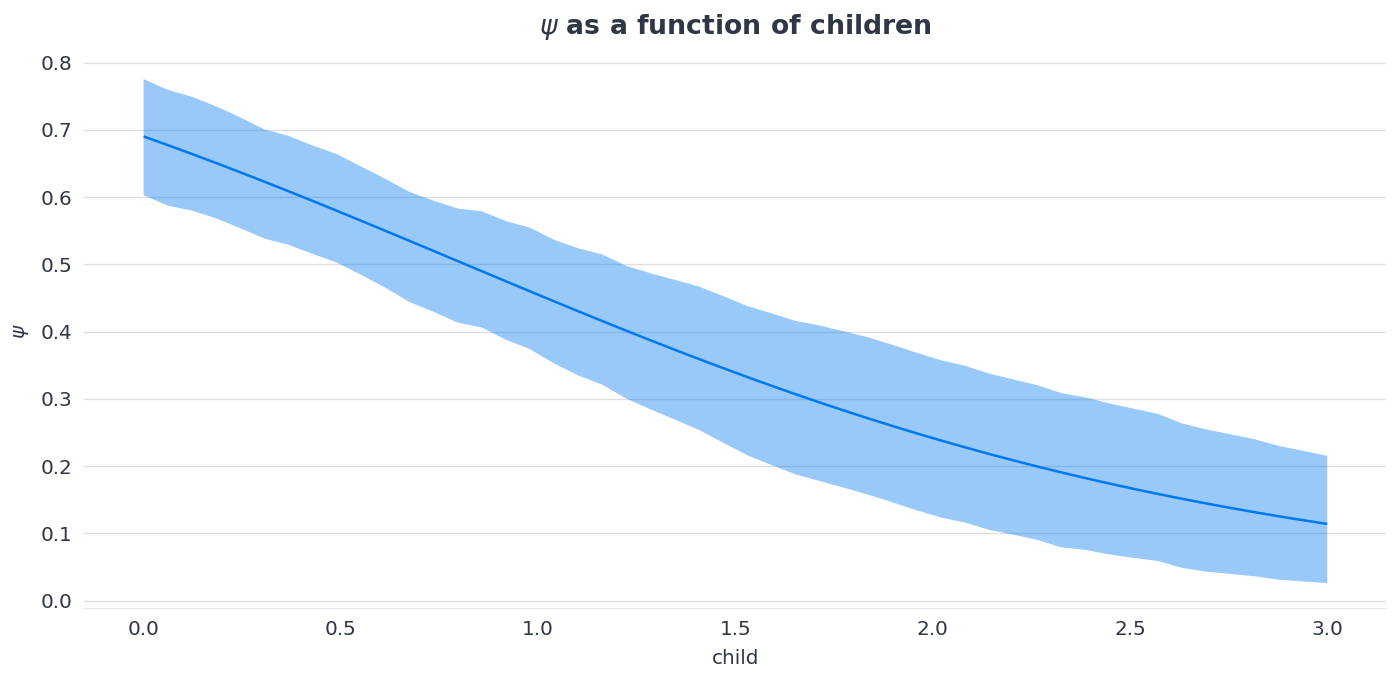

In [30]:
fig, (left, mid, right) = plt.subplots(1, 3, figsize=(14, 6), sharey=True)

bmb.interpret.plot_predictions(
    bmb_zip_model,
    bmb_zip_idata,
    conditional="persons",
    ax=left,
)
left.set(ylabel="Mean fish count ($\mu$)")

bmb.interpret.plot_predictions(
    bmb_zip_model,
    bmb_zip_idata,
    conditional="child",
    ax=mid,
)
mid.set(ylabel="")

bmb.interpret.plot_predictions(
    bmb_zip_model,
    bmb_zip_idata,
    conditional="camper",
    ax=right,
)
right.set(ylabel="")
fig.suptitle("$\mu$ as a function of the predictors", fontsize=24);
_, axes = bmb.interpret.plot_predictions(
    bmb_zip_model,
    bmb_zip_idata,
    conditional="child",
    target="psi",
    fig_kwargs=dict(figsize=(14, 6)),
)
axes[0].set(ylabel="$\psi$", title="$\psi$ as a function of children");

## PyMC Models
* ZIP
* ZINB

In [31]:
scaled_fish_data = fish_data.copy()
μ_persons, σ_persons = scaled_fish_data["persons"].mean(),  scaled_fish_data["persons"].std()
μ_persons, σ_persons

(2.528, 1.1127288341522217)

In [32]:
scaled_fish_data["scaled_persons"] = (scaled_fish_data["persons"] - μ_persons) / σ_persons

In [33]:
fish_coords = {"camper": scaled_fish_data["camper"].cat.categories}
fish_coords

{'camper': Index([0.0, 1.0], dtype='float32')}

In [37]:
# ZIP
with pm.Model(coords=fish_coords) as pymc_zip_model:
    
    # data
    campers_idx_ = pm.MutableData("camper_idx", scaled_fish_data["camper"].cat.codes.to_numpy())
    scaled_persons_ = pm.MutableData("scaled_persons", scaled_fish_data["scaled_persons"].to_numpy())
    child_ = pm.MutableData("child", scaled_fish_data["child"].to_numpy())
    
    # Poisson prior
    β_camper = pm.Normal("β_camper", 0, 0.5, dims="camper")
    β_scaled_person = pm.Normal("β_scaled_person", 0, 0.5)
    β_child = pm.Normal("β_child", 0, 0.5)
    
    # ψ priors (Logitic Regression)
    ψ_intercept = pm.Normal("ψ_intercept", 0, 0.5)
    ψ_child = pm.Normal("ψ_child", 0, 0.5)
    
    η = (
        β_camper[campers_idx_] + 
        β_scaled_person * scaled_persons_ + 
        β_child * child_
        )
    μ = pm.Deterministic("μ", pm.math.exp(η))
    ψ = pm.Deterministic(
        "ψ",
        pm.math.sigmoid(ψ_intercept + ψ_child * child_)
    )
#     print(λ.eval().shape)
    pm.ZeroInflatedPoisson("count", mu=μ, psi=ψ, observed=scaled_fish_data["count"].to_numpy(), shape=μ.shape)
    pymc_zip_idata = pm.sample(random_seed=1234, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [β_camper, β_scaled_person, β_child, ψ_intercept, ψ_child]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


In [34]:
# priors for α (#success)
scaled_fish_data["count"].agg(["mean", "std"])

mean     3.296000
std     11.635025
Name: count, dtype: float64

In [38]:
# ZINB
with pm.Model(coords=fish_coords) as pymc_zinb_model:
    
    # data
    campers_idx_ = pm.MutableData("camper_idx", scaled_fish_data["camper"].cat.codes.to_numpy())
    scaled_persons_ = pm.MutableData("scaled_persons", scaled_fish_data["scaled_persons"].to_numpy())
    child_ = pm.MutableData("child", scaled_fish_data["child"].to_numpy())
    
    # Poisson prior
    β_camper = pm.Normal("β_camper", 0, 0.5, dims="camper")
    β_scaled_person = pm.Normal("β_scaled_person", 0, 0.5)
    β_child = pm.Normal("β_child", 0, 0.5)
    
    # ψ priors (Logitic Regression)
    ψ_intercept = pm.Normal("ψ_intercept", 0, 0.5)
    ψ_child = pm.Normal("ψ_child", 0, 0.5)
    
    η = (
        β_camper[campers_idx_] + 
        β_scaled_person * scaled_persons_ + 
        β_child * child_
        )
    μ = pm.Deterministic("μ", pm.math.exp(η))
    α = pm.Gamma("α", mu=3, sigma=11)
    ψ = pm.Deterministic("ψ", pm.math.sigmoid(ψ_intercept + ψ_child * child_))

    pm.ZeroInflatedNegativeBinomial(
        "count", mu=μ, alpha=α, psi=ψ, observed=scaled_fish_data["count"].to_numpy(), shape=μ.shape
    )
    
    pymc_zinb_idata = pm.sample(random_seed=1234, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [β_camper, β_scaled_person, β_child, ψ_intercept, ψ_child, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


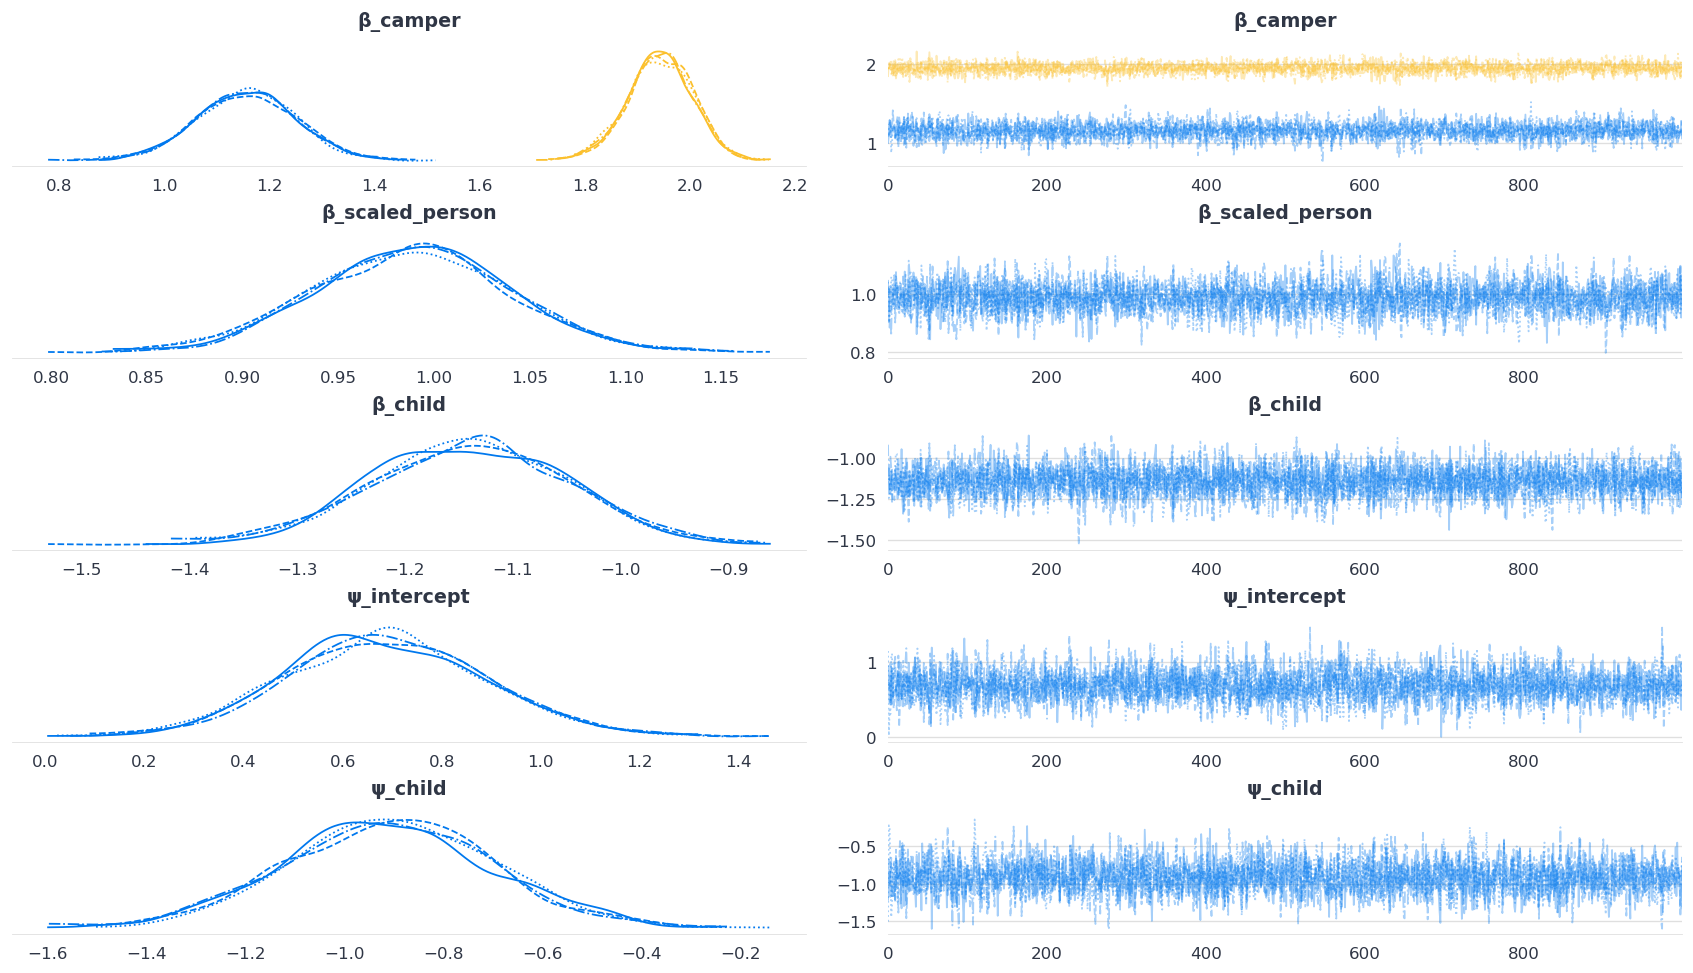

In [48]:
fig, axes = plt.subplots(5, 2, figsize=(14, 8), layout="constrained")
az.plot_trace(pymc_zip_idata, var_names=["~ψ", "~μ"], axes=axes);

In [39]:
az.summary(pymc_zip_idata, var_names=["~ψ", "~μ"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β_camper[0.0],1.156,0.095,0.977,1.331,0.002,0.001,3856.0,3292.0,1.0
β_camper[1.0],1.943,0.062,1.823,2.054,0.001,0.001,3259.0,2912.0,1.0
β_scaled_person,0.988,0.051,0.893,1.086,0.001,0.001,3014.0,2771.0,1.0
β_child,-1.141,0.091,-1.305,-0.965,0.001,0.001,4353.0,2990.0,1.0
ψ_intercept,0.688,0.201,0.324,1.076,0.003,0.003,3356.0,3138.0,1.0
ψ_child,-0.910,0.213,-1.327,-0.519,0.003,0.002,3766.0,3263.0,1.0


In [40]:
az.summary(pymc_zinb_idata, var_names=["~ψ", "~μ"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β_camper[0.0],0.926,0.192,0.572,1.278,0.003,0.002,4475.0,2828.0,1.0
β_camper[1.0],1.524,0.143,1.255,1.784,0.002,0.002,4745.0,2914.0,1.0
β_scaled_person,1.010,0.112,0.804,1.227,0.002,0.001,5188.0,3297.0,1.0
β_child,-0.927,0.246,-1.386,-0.467,0.004,0.003,3901.0,2943.0,1.0
ψ_intercept,1.489,0.286,0.974,2.038,0.004,0.003,4406.0,3086.0,1.0
ψ_child,-0.984,0.336,-1.561,-0.338,0.006,0.004,3960.0,1898.0,1.0
α,0.670,0.128,0.443,0.905,0.002,0.001,4689.0,3096.0,1.0


### Plots
* forest plots
* CAP (conditional adjusted predictions)

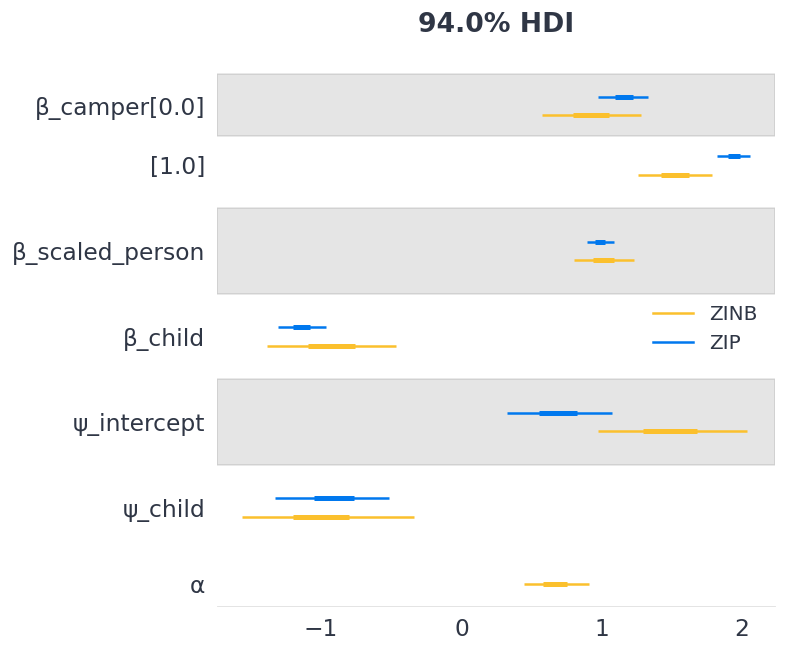

In [50]:
az.plot_forest(
    [pymc_zip_idata, pymc_zinb_idata],
    model_names=["ZIP", "ZINB"],
    var_names=["~ψ", "~μ"],
    combined=True,
    figsize=(6, 6)
);

#### Predictions
* data for conditional adjusted predictions
* keep covariates not present in conditional at their mean (if numbers) or mode (if categories).
    * non-conditioned variables are set to their mean (numbers) or mode (category)

In [51]:
features = ["persons", "child", "camper"]
dtypes = ["int", "int", "cat"]
n_unique_vals = scaled_fish_data[features].nunique().cumsum().iloc[-1]
n_unique_vals

10

In [52]:
scaled_fish_data["persons"].mean()

2.528

In [53]:
# create a dataset for CAP plot
test_data = np.zeros((n_unique_vals, len(features)))
i = 0
for j, (feature, dtype) in enumerate(zip(features, dtypes)):
    feature_vals = sorted(scaled_fish_data[feature].astype(np.int8).unique())
    test_data[:, j] = (
        scaled_fish_data[feature].astype(np.int8).mode().item() if dtype == "cat" else
        scaled_fish_data[feature].mean()  # (if numeric)
    )

    test_data[i:i+len(feature_vals), j] = feature_vals
    i += len(feature_vals)

cond_test_df = pd.DataFrame(test_data, columns=features)
cond_test_df["camper"] = cond_test_df["camper"].astype(np.int8)
cond_test_df["scaled_persons"] = (cond_test_df["persons"] - μ_persons) / σ_persons
cond_test_df

,persons,child,camper,scaled_persons
0,1.000,0.684,1,-1.373201
1,2.000,0.684,1,-0.474509
2,3.000,0.684,1,0.424182
3,4.000,0.684,1,1.322874
4,2.528,0.000,1,0.000000
5,2.528,1.000,1,0.000000
6,2.528,2.000,1,0.000000
7,2.528,3.000,1,0.000000
8,2.528,0.684,0,0.000000
9,2.528,0.684,1,0.000000


In [54]:
# * var_names=["μ", "ψ"] - predict posteriors instead of posterior samples
with pymc_zip_model:
    pm.set_data(
        {
            "camper_idx": cond_test_df["camper"].to_numpy(),
            "scaled_persons": cond_test_df["scaled_persons"].to_numpy(),
            "child": cond_test_df["child"].to_numpy(),
        }
    )
    pred_zip_idata = pm.sample_posterior_predictive(
        pymc_zip_idata,
        predictions=True,
        var_names=["μ", "ψ"],
        random_seed=1234
    )

Sampling: []


In [55]:
# * var_names=["μ", "ψ"] - predict posteriors instead of posterior samples
with pymc_zinb_model:
    pm.set_data(
        {
            "camper_idx": cond_test_df["camper"].to_numpy(),
            "scaled_persons": cond_test_df["scaled_persons"].to_numpy(),
            "child": cond_test_df["child"].to_numpy(),
        }
    )

    pred_zinb_idata = pm.sample_posterior_predictive(
        pymc_zinb_idata,
        predictions=True,
        var_names=["μ", "ψ"],
        random_seed=1234
    )

Sampling: []


In [57]:
pred_zip_idata.predictions

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 1000, μ_dim_2: 10, ψ_dim_2: 10)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * μ_dim_2  (μ_dim_2) int64 0 1 2 3 4 5 6 7 8 9
  * ψ_dim_2  (ψ_dim_2) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    μ        (chain, draw, μ_dim_2) float64 0.7171 1.837 4.708 ... 1.334 3.148
    ψ        (chain, draw, ψ_dim_2) float64 0.5287 0.5287 ... 0.5377 0.5377
Attributes:
    created_at:                 2024-02-03T13:20:12.607855
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.10.0

In [62]:
def cat_cap_plot(x: list[int], data: xr.DataArray, parameter_name: str, ax: plt.Axes, **kwargs) -> plt.Axes:
    """Conditional adjusted predictions for categorical variable"""
    hdi = az.hdi(data)[parameter_name]
    ax.scatter(x=feature_vals, y=data.mean(dim=("chain", "draw")).to_numpy(), 
               s=kwargs.get("s",20), marker=kwargs.get("marker","s"))
    ax.vlines(
        x=x,
        ymin=hdi.sel(hdi="lower"),
        ymax=hdi.sel(hdi="higher"),
        color=kwargs.get("color", "C0"),
        alpha=kwargs.get("alpha", 0.8)
    )
    
    return ax

def cap_plot(x: list[int], data: xr.DataArray, ax: plt.Axes, **kwargs) -> plt.Axes:
    """Conditional adjusted predictions for continuous variable"""
    ax.plot(x, data.mean(dim=("chain", "draw")).to_numpy(), color=kwargs.get("color", "C0"))
    az.plot_hdi(x, data, color=kwargs.get("color", "C0"), ax=ax)
    return ax

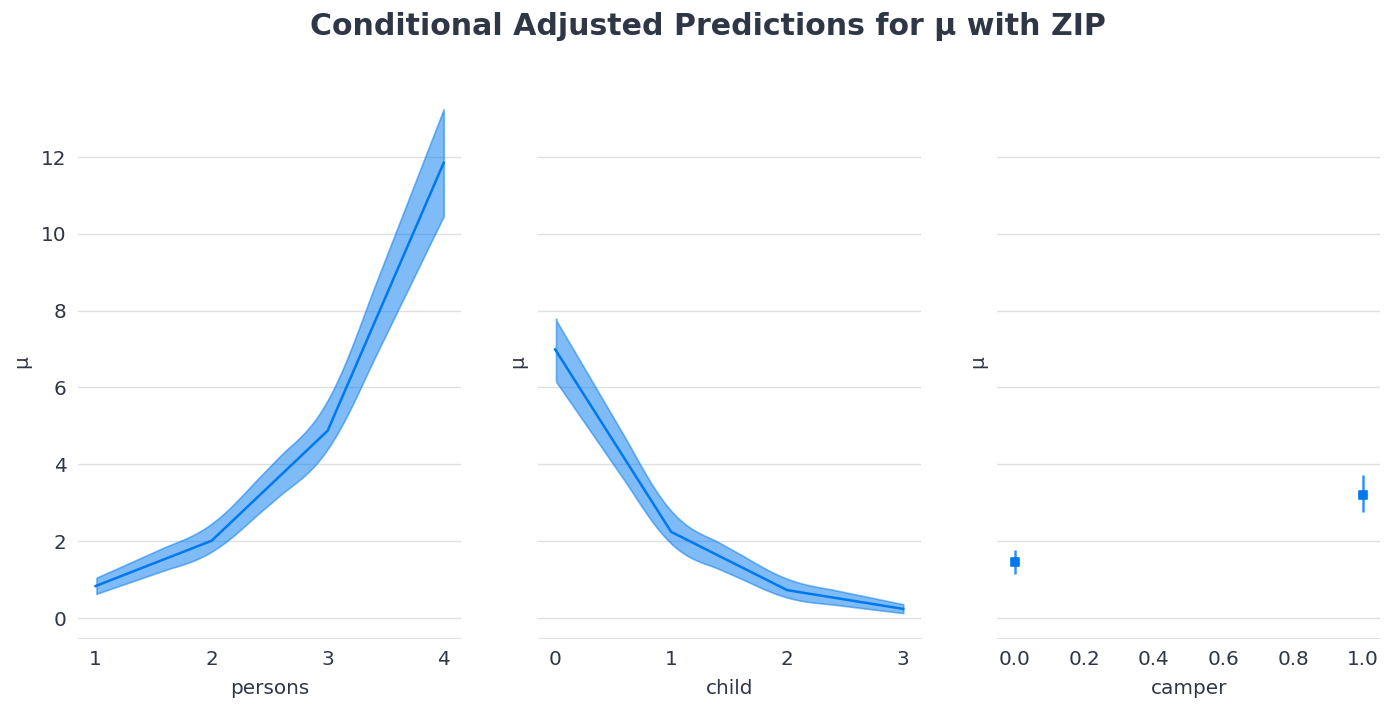

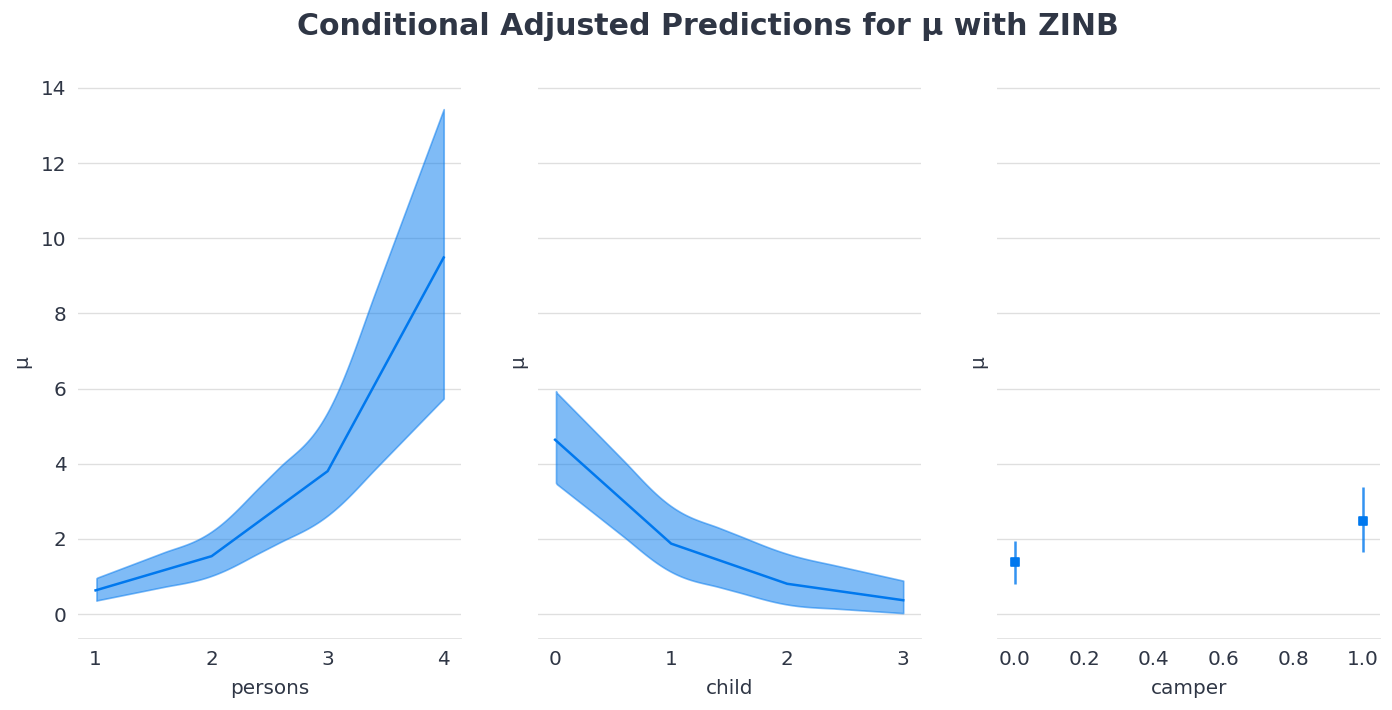

In [63]:

parameter_name="μ"
for idata, model_name in zip([pred_zip_idata, pred_zinb_idata], ["ZIP", "ZINB"]):
    i = 0
    fig, axes = plt.subplots(1, 3, figsize=(14, 6), sharey=True)
    for feature, dtype, ax in zip(features, dtypes, axes.ravel()):
        feature_vals = sorted(scaled_fish_data[feature].astype(np.int8).unique())
        preds = idata.predictions[parameter_name][:, :, i: i+len(feature_vals)]
        pred_zinb_idata, pred_zip_idata
        if dtype == "cat":
            ax = cat_cap_plot(
                x=feature_vals,
                data=preds,
                parameter_name=parameter_name,
                ax=ax
            )
        else:  # numerical
            ax = cap_plot(
                x=feature_vals,
                data=preds,
                ax=ax
            )
        ax.set(xlabel=feature, ylabel=parameter_name)

        i += len(feature_vals)
    fig.suptitle(f"Conditional Adjusted Predictions for {parameter_name} with {model_name}")

Text(0.5, 0.98, 'Conditional Adjusted Predictions for ψ with ZINB')

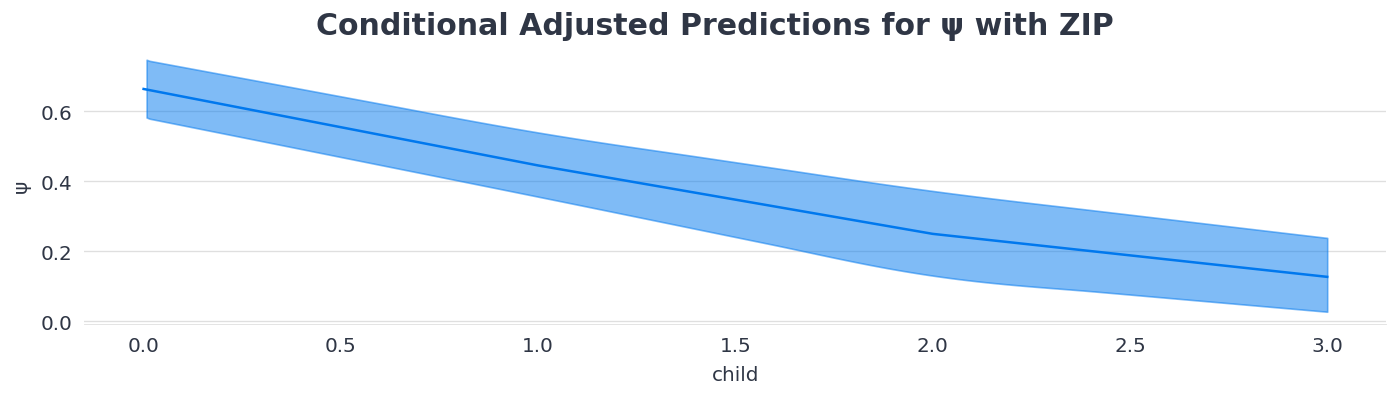

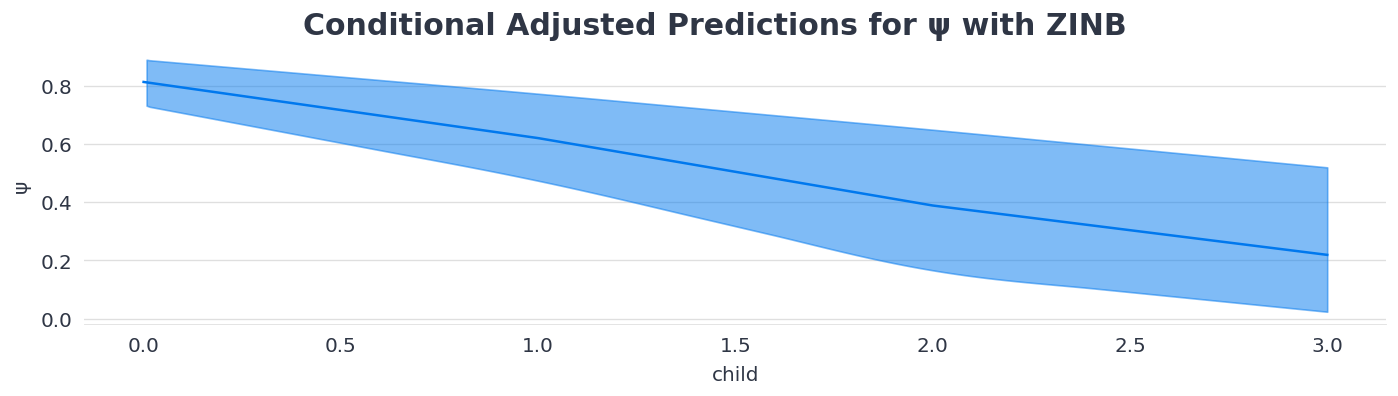

In [65]:
parameter_name="ψ"
fig, ax = plt.subplots(1, 1, figsize=(14, 3))
feature_vals = sorted(scaled_fish_data["child"].astype(np.int8).unique())
preds = pred_zip_idata.predictions[parameter_name][:, :, 4: 8]
ax = cap_plot(
        x=feature_vals,
        data=preds,
        ax=ax  
    )
ax.set(xlabel="child", ylabel=parameter_name)
fig.suptitle(f"Conditional Adjusted Predictions for {parameter_name} with ZIP" )

fig, ax = plt.subplots(1, 1, figsize=(14, 3))
feature_vals = sorted(scaled_fish_data["child"].astype(np.int8).unique())
preds = pred_zinb_idata.predictions[parameter_name][:, :, 4: 8]
ax = cap_plot(
        x=feature_vals,
        data=preds,
        ax=ax  
    )
ax.set(xlabel="child", ylabel=parameter_name)
fig.suptitle(f"Conditional Adjusted Predictions for {parameter_name} with ZINB" )